데이터 출처: 국내 통계포털 KOSIS

https://kosis.kr/statisticsList/statisticsListIndex.do?vwcd=MT_ZTITLE&menuId=M_01_01

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import pandas as pd
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic' 
year_lst = ['2016', '2017', '2018', '2019', '2020']
crim_lst = ['강력범죄', '절도범죄', '폭력범죄', '지능범죄', '풍속범죄', '교통범죄']
colors = ['#AF3248', '#CCCA6F', '#4A8A61', '#5B5EB7', '#9152A3', 'darkgray']

## 1. 워드클라우드를 이용하여 '연령별 범죄' 키워드 시각화

In [2]:
import requests
from pandas import DataFrame
from bs4 import BeautifulSoup
import re
from datetime import datetime
import os

date = str(datetime.now())
date = date[:date.rfind(':')].replace(' ', '_')
date = date.replace(':','시') + '분'

query =  '연령별 범죄'
news_num = 100 
query = query.replace(' ', '+')


news_url = 'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={}'

req = requests.get(news_url.format(query))
soup = BeautifulSoup(req.text, 'html.parser')


news_dict = {}
idx = 0
cur_page = 1

print()
print('크롤링 중...')
while idx < news_num:
### 네이버 뉴스 웹페이지 구성이 바뀌어 태그명, class 속성 값 등을 수정함(20210126) ###
    table = soup.find('ul',{'class' : 'list_news'})
    li_list = table.find_all('li', {'id': re.compile('sp_nws.*')})
    area_list = [li.find('div', {'class' : 'news_area'}) for li in li_list]
    a_list = [area.find('a', {'class' : 'news_tit'}) for area in area_list]
    for n in a_list[:min(len(a_list), news_num-idx)]:
        news_dict[idx] = {'title' : n.get('title'),
                          }
        idx += 1
    cur_page += 1
    pages = soup.find('div', {'class' : 'sc_page_inner'})
    next_page_url = [p for p in pages.find_all('a') if p.text == str(cur_page)][0].get('href')
    req = requests.get('https://search.naver.com/search.naver' + next_page_url)
    soup = BeautifulSoup(req.text, 'html.parser')


크롤링 중...


(-0.5, 816.5, 999.5, -0.5)

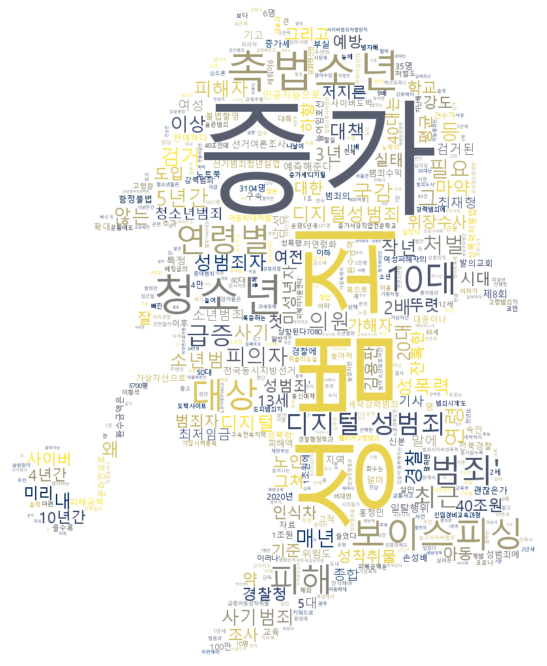

In [3]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

a = list(news_dict.values())  
text = "" 
for lst in a: 
    text += lst['title'] 
    
crim_mask= np.array(Image.open('sherlock.png'))  
stopword=set(STOPWORDS) 
stopword.add('중')
stopword.add('범죄')
wc = WordCloud(font_path = 'C:\Windows\Fonts\\malgun.ttf', background_color='white',max_words=1500,mask=crim_mask, 
               stopwords= stopword, colormap = 'cividis_r').generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')

## 인구 데이터 로드

In [4]:
population = pd.read_csv('연령_및_성별_인구__읍면동_2015_2020___시군구_20162019__20211105215933.csv', encoding = 'cp949')
population = population.set_index('연령별')

p1 = population.columns.map(lambda x : x[:4]) 
p2 = population.iloc[0].map(lambda x : x.split(' ')[0])

population.columns = [p1, p2]         
population.drop(['행정구역'], axis = 1, inplace = True)
population = population.iloc[1:].replace('-', 0).astype(float)
population.columns.names = ['년도', '구분'] 

c:\users\svbea\appdata\local\programs\python\python39\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


## 범죄 데이터 로드

In [5]:
criminal = pd.read_csv('범죄자_범행시_연령_20211105215356.csv', encoding = 'cp949')
criminal = criminal.copy()
criminal = criminal.set_index(['죄종별(1)', '죄종별(2)']) 

c1 = criminal.columns.map(lambda x : x[:4])  
c2 = criminal.iloc[0].map(lambda x : x.split(' ')[0]) 
c3 = criminal.iloc[1].map(lambda x : x.split(' ')[0])  

criminal.columns = [c1, c2, c3]       
criminal = criminal.iloc[1:]
criminal.columns.names = ['연도', '성년', '나이']  
criminal = criminal[1:].replace('-',0).astype(int)

## 재범 데이터 로드

In [6]:
ex_convict = pd.read_csv('전과범죄자_범행시_연령_20211105220425.csv', encoding = 'cp949')
ex_convict = ex_convict.copy()
ex_convict = ex_convict.set_index(['죄종별(1)', '죄종별(2)']) 

e1 = ex_convict.columns.map(lambda x : x[:4]) 
e2 = ex_convict.iloc[0].map(lambda x : x.split(' ')[0]) 
e3 = ex_convict.iloc[1].map(lambda x : x.split(' ')[0]) 

ex_convict.columns = [e1, e2, e3]         
ex_convict = ex_convict.iloc[1:]
ex_convict.columns.names = ['연도', '성년', '나이']   
ex_convict = ex_convict[1:].replace('-', 0).astype(int)

## 인구 15~19 연도별로 뽑기

In [7]:
age15_19 = []
for year in year_lst:
    age15_19.append(population[year].loc['15~19세', ['총인구(명)']].values)
age15_19 = np.array(age15_19).reshape(-1).astype(int)
age15_19_df = pd.DataFrame(age15_19, columns = ['15~19세'], index = year_lst)

## 연도별 범죄 6종 소계 df, long df
- 자르고싶다면 crim_detail_df // crim_total = [] 사이, crim_total_df // crim_total_6 = [] 사이
- crim_total_6_df // crim_total_6_long_df 사이 자르세여~

In [8]:
crim_all_columns = ['강력범죄','절도범죄','폭력범죄','지능범죄','풍속범죄','교통범죄','특별경제범죄',
                     '마약범죄','보건범죄', '환경범죄','노동범죄','안보범죄','선거범죄','병역범죄','기타범죄']
crim_detail_number = []
for year in year_lst:
    tmp = criminal[year]['미성년'].loc[:,['15세', '16세', '17세', '18세']]
    tmp['19세'] = criminal[year]['성년'].loc[:,['19세']]
    tmp = tmp.sum(axis = 1)
    crim_detail_number.append(tmp)
crim_detail_df = pd.DataFrame(crim_detail_number, index = year_lst)

crim_total = []
for i in range(5):
    tmp = []
    for crim in crim_all_columns:
        tmp.append(crim_detail_df.iloc[i].loc[crim].loc['소계'])
    crim_total.append(tmp)
crim_total_df = pd.DataFrame(crim_total, index = year_lst, columns = crim_all_columns).T

crim_total_6 = []
for i in range(5):
    tmp = []
    for crim in crim_lst:
        tmp.append(crim_detail_df.iloc[i].loc[crim].loc['소계'])
    crim_total_6.append(tmp)   
crim_total_6 = np.array(crim_total_6).T
crim_total_6_df = pd.DataFrame(crim_total_6,
                         index = crim_lst,
                         columns = year_lst)

crim_total_6_long_df = pd.DataFrame(crim_total_6.T.reshape(-1, 1), columns = ["소계"])
crim_total_6_long_df['죄종별'] = crim_lst * 5
base = np.array(year_lst).reshape(-1, 1)
year = np.concatenate([base, base, base, base, base, base], axis = 1).reshape(-1, 1)
crim_total_6_long_df['연도별'] = year

## 그래프 - 범죄 6종  (가로막대그래프 그린거는 코드가 길어서 따로 뺌)
- 자르고싶다면 def끼리 자르는 방법밖에.. 이건 한 번에 쓰는게 좋을 듯

In [9]:
def make_survey(data, txt):
    results = {'2016':data['2016'], '2017':data['2017'], '2018':data['2018'], '2019':data['2019'], '2020':data['2020']}
    survey(results, crim_lst, txt)

def survey(results, crim_lst, txt):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    for i, (colname, color) in enumerate(zip(crim_lst, colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5, label=colname, color=color)
        text_color = 'black'
        ax.bar_label(rects, label_type='center', color=text_color)
        ax.legend(ncol=len(crim_lst), bbox_to_anchor=(1, 0), loc='upper right', fontsize='small')
        plt.title('연도별 15~19세 ' + txt + ' 유형')
    return fig, ax

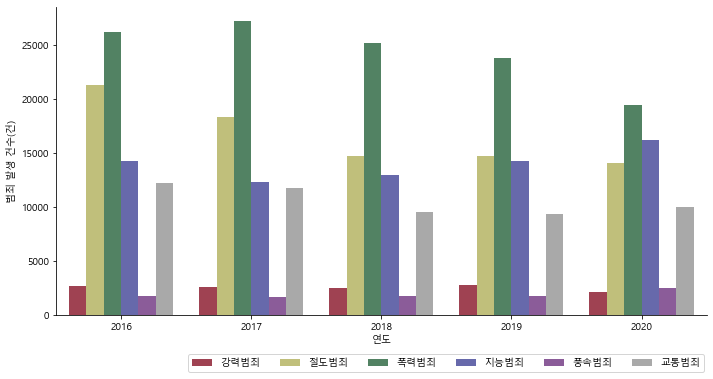

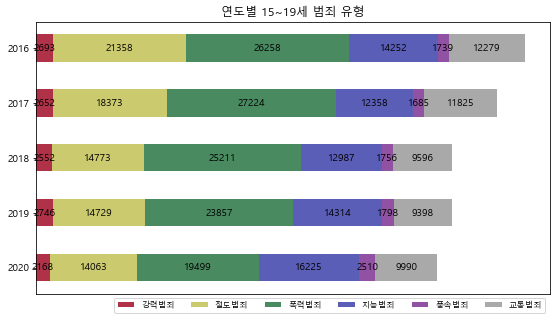

In [10]:
sns.catplot(data = crim_total_6_long_df, x = "연도별", y = "소계", hue = "죄종별", 
            kind = "bar", aspect = 2, palette = colors, legend = False)
plt.legend(loc="lower center", ncol = 6, bbox_to_anchor=(0.6, -0.2))
plt.xlabel("연도")
plt.ylabel("범죄 발생 건수(건)")
plt.show()

make_survey(crim_total_6_df, '범죄')

## 그래프 - 범죄율(15~19 인구 대비)
- 코드 사진이 크다면 plt.show()에서 잘라 쓰세여~

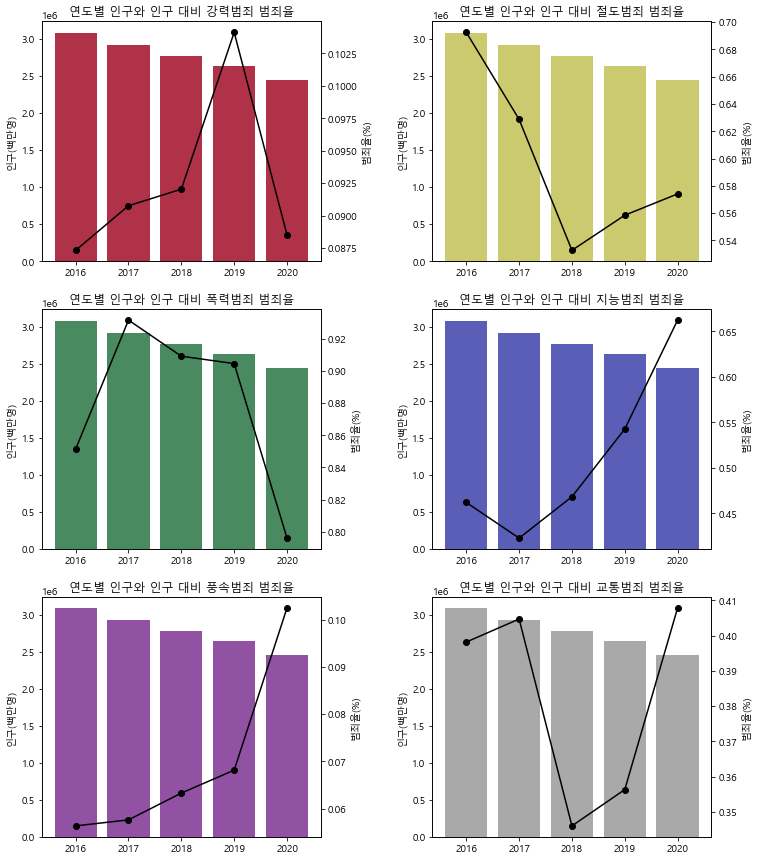

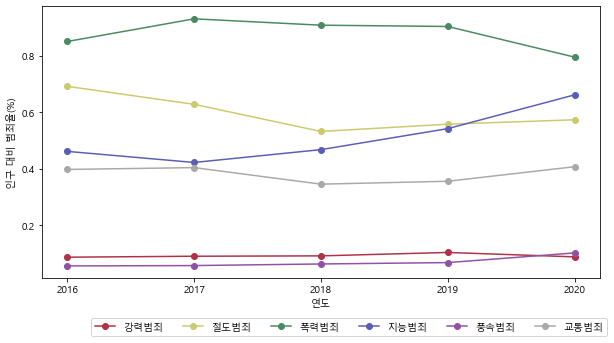

In [11]:
crim_pop_pct = crim_total_6_df.values / age15_19_df.values.T * 100

fig = plt.figure(figsize=(12,15))
plt.subplots_adjust(wspace=0.4)
for i, crim in enumerate(crim_lst):
    ax = fig.add_subplot(3, 2, i + 1)
    ax.set_title("연도별 인구와 인구 대비 " + crim + " 범죄율")
    ax.set_ylabel("인구(백만명)")
    plt.bar(x = year_lst, height = age15_19_df.loc[:,'15~19세'], color = colors[i])
    ax2 = ax.twinx()
    ax2.set_ylabel("범죄율(%)")
    ax2.plot(year_lst, crim_pop_pct[i], marker = 'o', color = 'k')
plt.show()

fig = plt.figure(figsize = (10, 5))
for i in range(6):
    plt.xlabel("연도")
    plt.ylabel("인구 대비 범죄율(%)")
    plt.plot(year_lst, crim_pop_pct[i], marker = 'o', label = crim_lst[i], color = colors[i])   
plt.legend(loc = "lower center", ncol = 6, bbox_to_anchor = (0.55, -0.23))
plt.show()

## 재범 6종 상세 df, 연도별 재범 6종 소계, long df
- 잘라서 사용하고싶다면 ex_detail_df // ex_total_6 사이, ex_total_6_df // dx_total_6_long_df 사이에서 자르세여~

In [12]:
ex_detail_number = []
for year in year_lst:
    tmp = ex_convict[year]['미성년'].loc[['계', '강력범죄', '절도범죄', '폭력범죄', '지능범죄',
                                    '풍속범죄', '교통범죄']].loc[:, ['15세', '16세', '17세', '18세']]
    tmp['19세'] = ex_convict[year]['성년'].loc[['계', '강력범죄', '절도범죄', '폭력범죄', 
                                             '지능범죄', '풍속범죄', '교통범죄'],['19세']]
    tmp = tmp.sum(axis = 1)
    ex_detail_number.append(tmp)
ex_detail_df = pd.DataFrame(ex_detail_number, index = year_lst)

ex_total_6 = []
for i in range(5):
    tmp = []
    for crim in crim_lst:
        tmp.append(ex_detail_df.iloc[i].loc[crim].loc['소계'])
    ex_total_6.append(tmp)  
ex_total_6 = np.array(ex_total_6).T
ex_total_6_df = pd.DataFrame(ex_total_6, index = crim_lst, columns = year_lst)

ex_total_6_long_df = pd.DataFrame(ex_total_6.T.reshape(-1, 1), columns = ["소계"])
ex_total_6_long_df['죄종별'] = crim_lst * 5
base = np.array(year_lst).reshape(-1, 1)
year = np.concatenate([base, base, base, base, base, base], axis = 1).reshape(-1, 1)
ex_total_6_long_df['연도별'] = year

## 그래프 - 재범 6종 그래프, 유형 그래프(가로막대)

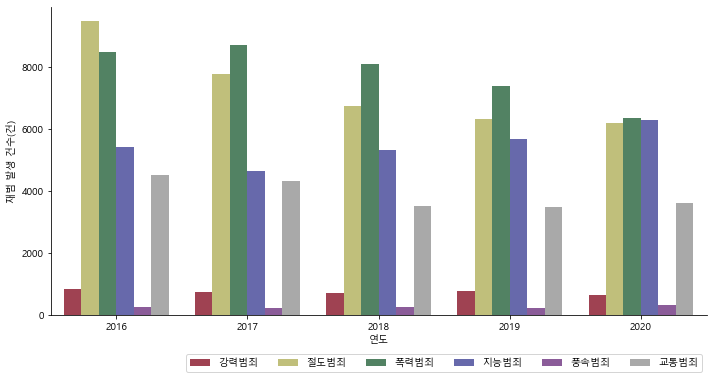

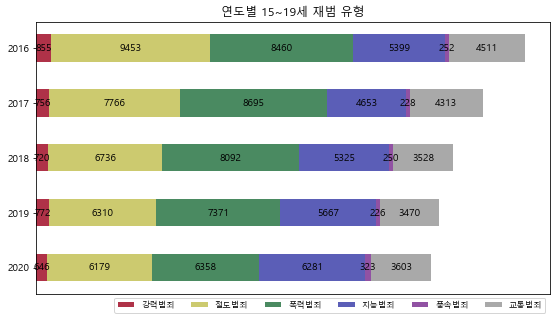

In [13]:
sns.catplot(data = ex_total_6_long_df, x = "연도별", y = "소계", hue = "죄종별", 
            kind = "bar", aspect = 2, palette = colors, legend = False)
plt.legend(loc="lower center", ncol = 6, bbox_to_anchor=(0.6, -0.2))
plt.xlabel("연도")
plt.ylabel("재범 발생 건수(건)")
plt.show()

make_survey(ex_total_6_df, '재범')

## 죄종별 범죄 건수 대비 재범 건수 (재범 건수 / 범죄 건수)와 그래프
- 그림이 크면 plt.show()에서 자르세여~

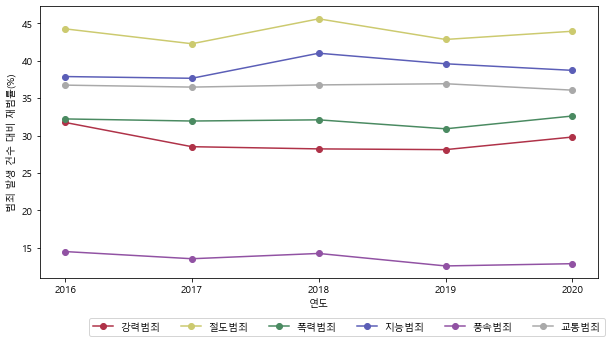

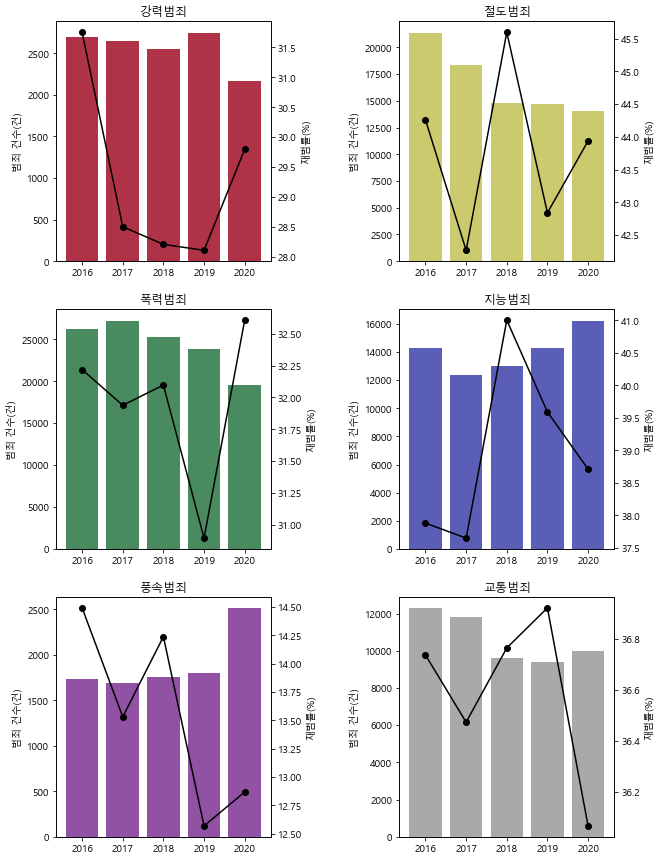

In [14]:
ex_kind_pct = ex_total_6 / crim_total_6 * 100

fig = plt.figure(figsize = (10, 5))
for i in range(6):
    plt.xlabel("연도")
    plt.ylabel("범죄 발생 건수 대비 재범률(%)")
    plt.plot(year_lst, ex_kind_pct[i], marker = 'o', label = crim_lst[i], color = colors[i])
plt.legend(loc = "lower center", ncol = 6, bbox_to_anchor = (0.55, -0.23))
plt.show()

fig = plt.figure(figsize=(10,15))
plt.subplots_adjust(wspace=0.6)
for i, crim in enumerate(crim_lst):
    ax = fig.add_subplot(3, 2, i + 1)
    ax.set_title(crim)
    ax.set_ylabel("범죄 건수(건)")
    plt.bar(x = year_lst, height = crim_total_6[i], color = colors[i])
    ax2 = ax.twinx()
    ax2.set_ylabel("재범률(%)")
    ax2.plot(year_lst, ex_kind_pct[i], marker = 'o', color = 'k')    
plt.show()    